In [0]:
import numpy as np
import pandas as pd
import ast
from collections import Counter
import os
import json
from pandas.io.json import json_normalize
import unicodedata
import re
from matplotlib import pyplot as plt


In [0]:
def addDateFeatures(data):
    """ Adds extra date features like: day, month, quarter and year """
    data['release_year'] = pd.to_datetime(data['release_date']).dt.year
    data['release_quarter'] = pd.to_datetime(data['release_date']).dt.quarter
    data['release_month'] = pd.to_datetime(data['release_date']).dt.month
    data['release_day'] = pd.to_datetime(data['release_date']).dt.day

    data['release_year'].loc[data['release_year'] > 2019] -= 100 # Fixing release years.

    # Filling the columns NaN values (only one NaN value exist in test data) with mode of the data
    data['release_year'].fillna(data['release_year'].mode()[0],inplace = True)
    data['release_quarter'].fillna(data['release_quarter'].mode()[0],inplace = True)
    data['release_month'].fillna(data['release_month'].mode()[0],inplace = True)
    data['release_day'].fillna(data['release_day'].mode()[0],inplace = True)

    data['release_year'] = data['release_year'].astype(int)
    data['release_quarter'] = data['release_quarter'].astype(int)
    data['release_month'] = data['release_month'].astype(int)
    data['release_day']= data['release_day'].astype(int)

    # Reshape the release date column to from this format: 'month-day-year' to this format: 'year-month-day'
    data['release_date'] = data['release_month'].astype(str) + '/' + data['release_day'].astype(str) + '/' + data['release_year'].astype(str)
    data['release_date'] = pd.to_datetime(data['release_date'], format="%m/%d/%Y")
    data['release_day_of_week'] = data['release_date'].dt.dayofweek # The day of the week with Monday = 0, Sunday = 6
    return data

def addExtraFeatures(data):
    """ Adds extra features """
    pass

def stringToJSON(data):
    """ change strings to JSON format for a pandas coloumn """
    data.fillna(value = '[{}]',inplace = True) # JSON empty string format
    data.loc[data == '[]'] = '[{}]'
    return data.apply(lambda entry: re.compile(r'\\x([0-9a-fA-F]{2})').sub('',entry.replace("None",'"ddd"'))).apply(ast.literal_eval)

def addGenreFeatures(data):
    """ Adds extra features """
    #data['genre'] = stringToJSON(data['genres'])
    #train_genres = pd.DataFrame(
    #{
    #    'id' : data['id'].values.repeat(data['genres'].str.len(), axis = 0),
    #    'genre' : np.concatenate(data['genres'].tolist())
    #})

    #train_genres['genre'] = train_genres['genre'].map(lambda genre: genre.get('name'))
    #train_genres = train_genres.set_index('id').genre.str.get_dummies().sum(level = 0)
    #data = pd.merge(data, train_genres, on = 'id', how = 'outer')

    '''Adds the num_genres and ont hot encoding of genres'''
    list_of_genres = list(data['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)

    genres_unique = set(x for l in list_of_genres for x in l)
    data['num_genres'] = data['genres'].apply(lambda x: len(x) if x != {} else 0)
    data['all_genres'] = data['genres'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    
    for genre in genres_unique:
        data[genre] = data['all_genres'].apply(lambda x: 1 if genre in x else 0)
    
    #train = train.drop(['genres', 'all_genres'], axis=1)
    return data

def is_en(df):
    df['is_english'] = 0
    df.loc[train['original_language']=="en", 'is_english'] = 1
    return df

def cast_preproccessing(train):
    cast_list = []
    male = 0
    female = 0
    Hero_male = 0
    Hero_female = 0

    for x in train['cast']:
        try:
            for item in ast.literal_eval(x):
                cast_list.append(item['name'])
                if item['order'] == 0:
                    if item['gender'] == 1:
                        Hero_female += 1
                    else:
                        Hero_male += 1

                if item['gender'] == 1:
                    female += 1
                else:
                    male += 1
        except:
            continue
    return cast_list,male,female,Hero_male,Hero_female

def is_famous(df):
    output = cast_preproccessing(df)
    c = Counter(output[0])
    list_freq = [i[0] for i in c.most_common(50)]
    for i in list_freq[:15]:
        df[i] = 0
    df['is Famous'] = 0
    df['numberOfCast'] = 0
    df['Male_cast'] = 0
    df['Female_cast'] = 0
    df['unknown_gender_cast'] = 0
    for idx, row in df.iterrows():
        try:
            df['numberOfCast'][idx] = len(ast.literal_eval(row['cast']))
            for item in ast.literal_eval(row['cast']):
                if item['name'] in list_freq:
                    df['is Famous'][idx]=1
                if item['name'] in list_freq[:15]:
                    df[item['name']][idx]=1
                if item['gender'] == 2:
                  df['Male_cast'][idx] +=1
                elif item['gender'] == 1:
                  df['Female_cast'][idx] +=1
                else:
                  df['unknown_gender_cast'][idx] += 1 
        except:
            continue
    return df

def add_production_companies_features(df):
    list_of_companies = list(df['production_companies'].apply(lambda x: [i['name'].replace(' ', '') for i in x] if x != {} else []).values)
    top_companies = [list(m) for m in Counter([i for j in list_of_companies for i in j]).most_common(10)]
    top_companies = pd.DataFrame(data=top_companies, columns=['Production Company', 'Number of Productions'])
    top_production_companies = top_companies['Production Company']
    df['num_companies'] = df['production_companies'].apply(lambda x: len(x) if x != {} else 0)
    df['all_companies'] = df['production_companies'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_companies:
        df[ 'is_by_'+company] = df['all_companies'].apply(lambda x: 1 if company in x else 0)
    
    return df

def add_production_countries_features(df):
    list_of_production_countries = list(df['production_countries'].apply(lambda x: [i['name'].replace(' ', '') for i in x] if x != {} else []).values)
    top_countries = [list(m) for m in Counter([i for j in list_of_production_countries for i in j]).most_common(10)]
    top_countries = pd.DataFrame(data=top_countries, columns=['Production Country', 'Number of Productions'])
    top_production_countries = top_countries['Production Country'] 
    df['num_countries'] = df['production_countries'].apply(lambda x: len(x) if x != {} else 0)
    df['all_countries'] = df['production_countries'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    for company in top_production_countries:
        df[ 'is_by_'+company] = df['all_countries'].apply(lambda x: 1 if company in x else 0)
    
    return df

def add_keywords_features(df):
    allKeywords = list(df['Keywords'].apply(lambda x: [i['name'] for i in x] if x != {} else []).values)
    df['num_of_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['allKeywords'] = df['Keywords'].apply(lambda x: ' '.join(sorted([i['name'] for i in x])) if x != {} else '')
    top_keywords = [m[0] for m in Counter([i for j in allKeywords for i in j]).most_common(10)]
    for key_word in top_keywords:
        df['includes_' + key_word] = df['allKeywords'].apply(lambda x: 1 if key_word in x else 0)
    return df

def add_crew_features(df):
    df['numberOfCrew'] = df['crew'].apply(lambda x: len(x) if x != {} else 0)
    df['unknown_gender_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['Female_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['Male_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))
    return df

# creating features based on dates
def add_release_date_features(df):
    date_parts = ["year", "weekday", "month", 'weekofyear', 'day', 'quarter']
    for part in date_parts:
        part_col = 'release_date' + "_" + part
        df[part_col] = getattr(df['release_date'].dt, part).astype(int)
    
    return df

In [0]:
### helper functions:
def text_to_dict(df, dict_columns):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df

In [109]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### Load the data
train = pd.read_csv('drive/My Drive/train.csv')
test = pd.read_csv('drive/My Drive/test.csv')

In [0]:
columns_to_change = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'crew']

# change the strings into list of dictionaries
train = text_to_dict(train, columns_to_change)
test = text_to_dict(test, columns_to_change)
train['belongs_to_collection'] = train['belongs_to_collection'].apply(lambda x: 1 if x != {} else 0)

In [131]:
#### add all features:
train = addGenreFeatures(train)
train = addDateFeatures(train)
train = add_production_companies_features(train)
train = add_production_countries_features(train)
train = is_en(train)
train = is_famous(train)
train = add_release_date_features(train)
train = add_keywords_features(train)
train = add_crew_features(train)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:106: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1

In [132]:
train.columns.values

array(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'Keywords',
       'cast', 'crew', 'revenue', 'num_genres', 'all_genres', 'Foreign',
       'Comedy', 'Drama', 'Adventure', 'Music', 'Science Fiction',
       'TV Movie', 'Horror', 'Fantasy', 'Family', 'War', 'Western',
       'Animation', 'History', 'Mystery', 'Crime', 'Documentary',
       'Thriller', 'Action', 'Romance', 'release_year', 'release_quarter',
       'release_month', 'release_day', 'release_day_of_week',
       'num_companies', 'all_companies', 'is_by_WarnerBros.',
       'is_by_UniversalPictures', 'is_by_ParamountPictures',
       'is_by_TwentiethCenturyFoxFilmCorporation',
       'is_by_ColumbiaPictures', 'is_by_Metro-Goldwyn-Mayer(MGM)',
       'is_by_NewLineC

In [0]:
pip install eli5

In [0]:
from sklearn.model_selection import train_test_split, KFold
from lightgbm import LGBMRegressor as BoostedRegressor
import eli5 as ModelDebugger


In [0]:
### Model 1: With no extra features and no fixes applied
features = train.drop(['id', 'genres', 'homepage', 'imdb_id', 'original_language', 'original_title', 'overview',\
                      'poster_path', 'production_companies', 'production_countries', 'release_date', \
                      'spoken_languages', 'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', \
                      'all_companies', 'allKeywords', 'all_genres','all_countries'], axis=1)


In [0]:
X = features.drop([ 'revenue'], axis=1)
y = np.log1p(features['revenue'])
X_test = test.drop(['id'], axis=1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)


In [0]:
regressor_parameters = {'num_leaves': 30,
          'min_data_in_leaf': 20,
         'objective': 'regression',
         'max_depth': 5,
         'learning_rate': 0.01,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse', 
         "lambda_l1": 0.2,
         "verbosity": -1} 
## TODO: tune the lambda_l1 for L1 regularization and the learning rate and the number of estimators in the regressor itself


In [0]:
## model creation
model_trail_1 = BoostedRegressor(**regressor_parameters, n_estimators = 20000, nthread = 4, n_jobs = -1)

In [137]:
model_trail_1.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
        verbose=1000, early_stopping_rounds=200)

#### veeeeeryyyy large RMSE !! features are not good

Training until validation scores don't improve for 200 rounds.
[1000]	training's rmse: 1.46098	valid_1's rmse: 1.97956
Early stopping, best iteration is:
[954]	training's rmse: 1.47558	valid_1's rmse: 1.97816


LGBMRegressor(bagging_fraction=0.9, bagging_freq=1, bagging_seed=11,
              boosting='gbdt', boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, feature_fraction=0.9,
              importance_type='split', lambda_l1=0.2, learning_rate=0.01,
              max_depth=5, metric='rmse', min_child_samples=20,
              min_child_weight=0.001, min_data_in_leaf=20, min_split_gain=0.0,
              n_estimators=20000, n_jobs=-1, nthread=4, num_leaves=30,
              objective='regression', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [138]:
### debug the model to see features significances
ModelDebugger.show_weights(model_trail_1, feature_filter=lambda x: x != '<BIAS>')

Weight,Feature
0.4484,budget
0.1534,popularity
0.0704,release_year
0.0363,runtime
0.0326,Male_crew
0.0203,release_date_weekofyear
0.0194,release_day
0.0173,numberOfCast
0.0162,Male_cast
0.0158,belongs_to_collection


Plotting metrics recorded during training...


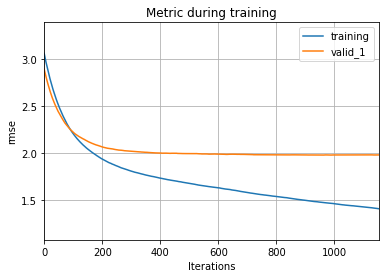

In [140]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(booster = model_trail_1, metric='rmse')
plt.show()